<a href="https://colab.research.google.com/github/diegosfc91/EJERCICIOS-DE-CORE-Machine-Learning/blob/main/Predicci%C3%B3n_de_Calidad_del_Vino_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Carga y Exploración de Datos:

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB
None

Primeras filas del dataset:
   fixed acidity

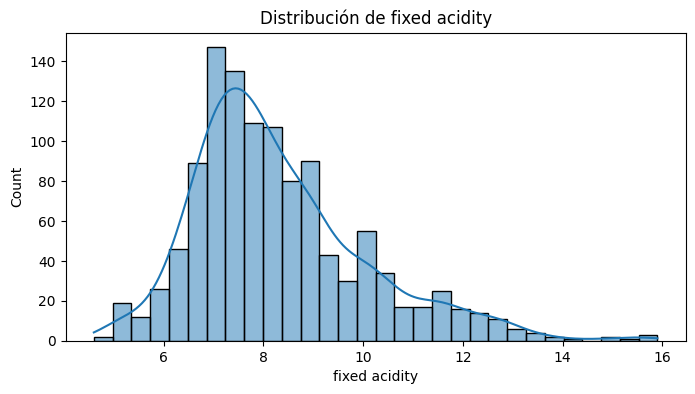

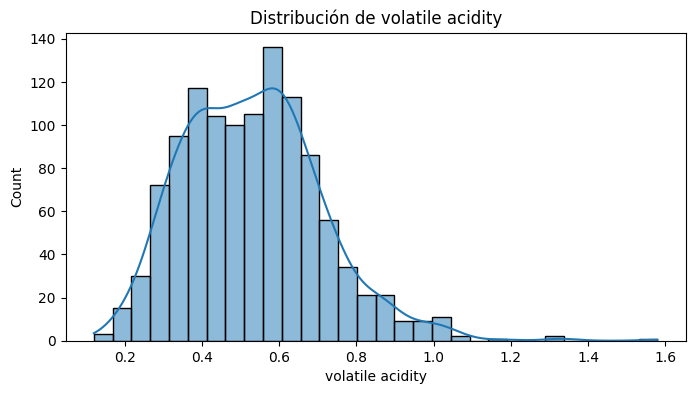

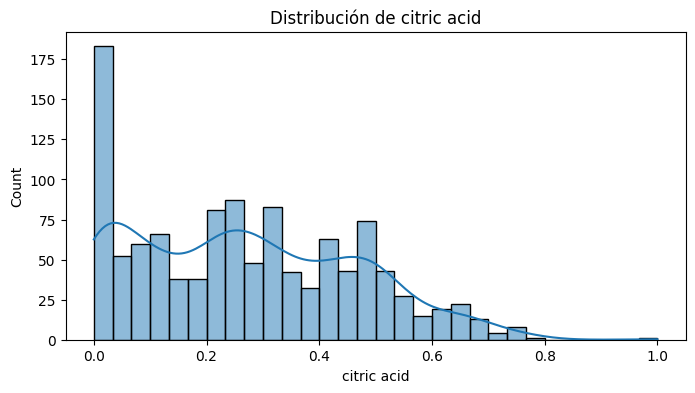

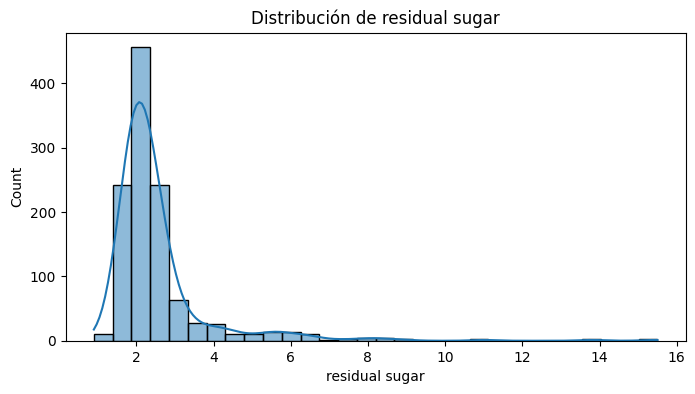

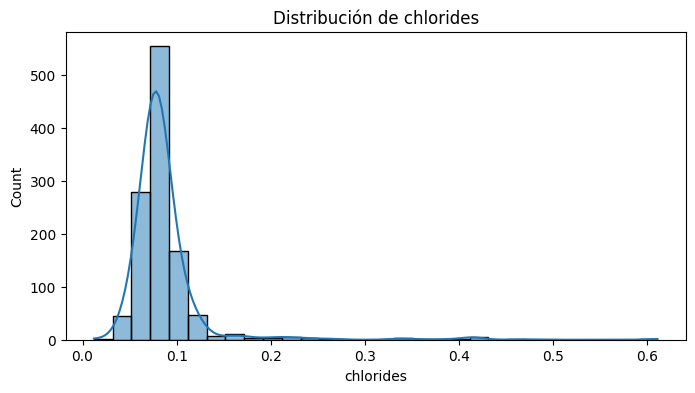

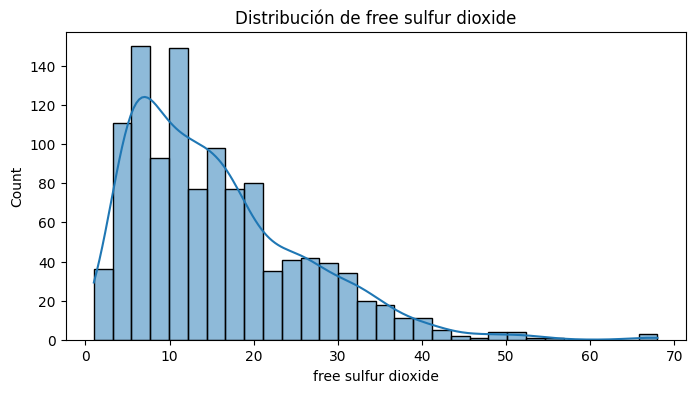

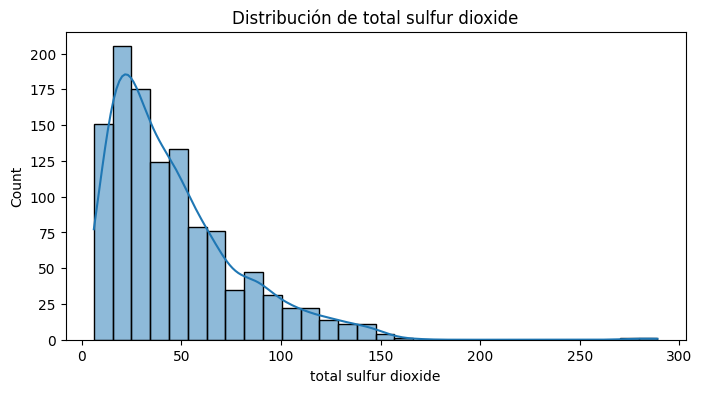

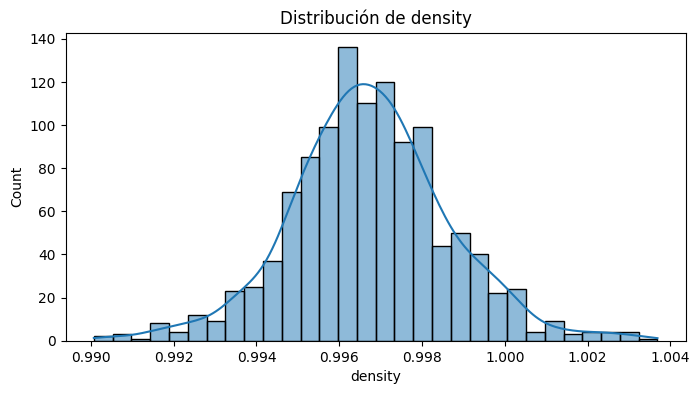

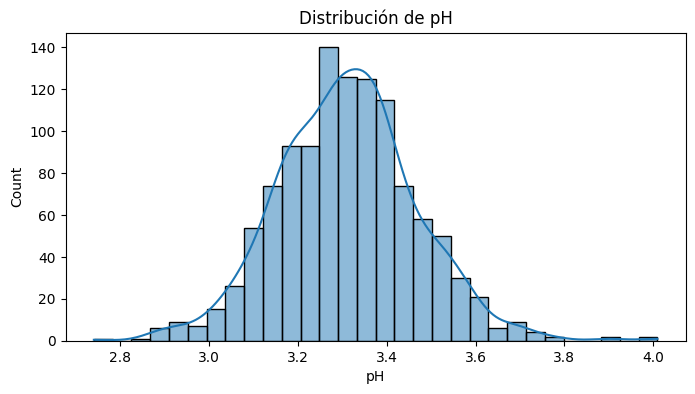

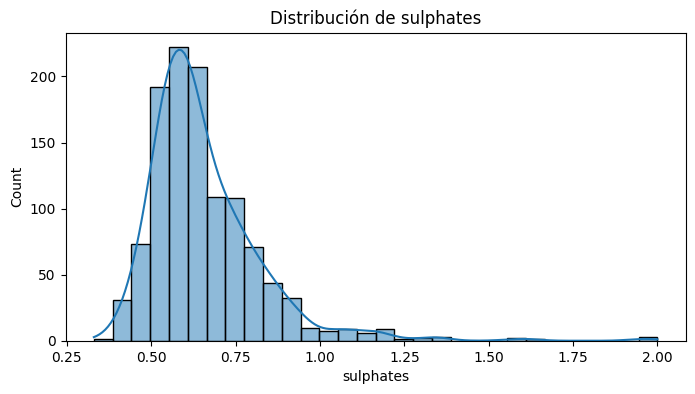

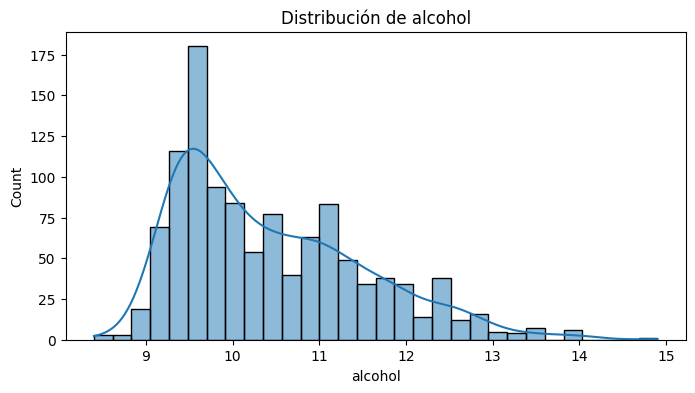

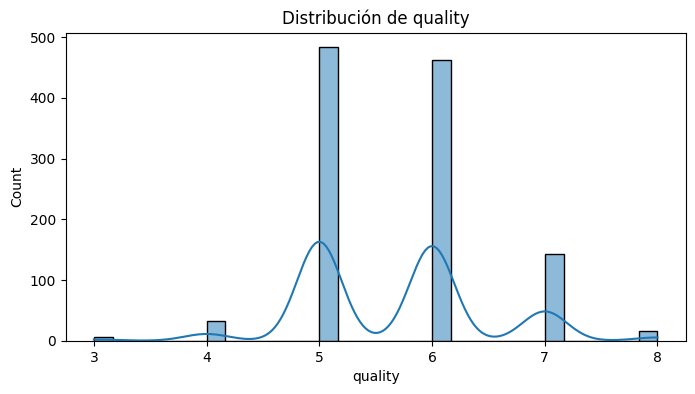

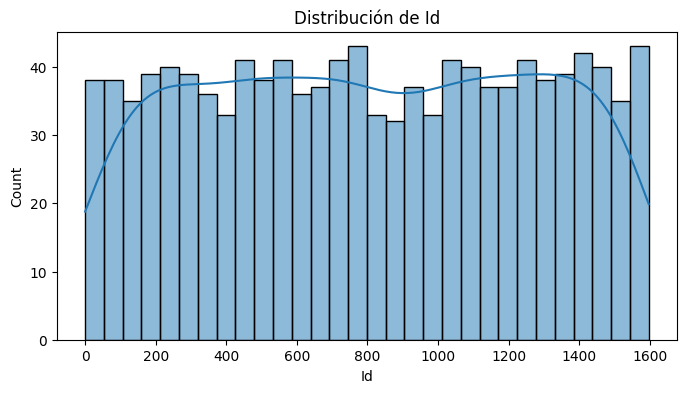


Valores nulos por columna:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64

Descripción estadística después del tratamiento de outliers:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.269991          0.529884     0.268290        2.323141   
std         1.630215          0.174273     0.196425        0.609600   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.6

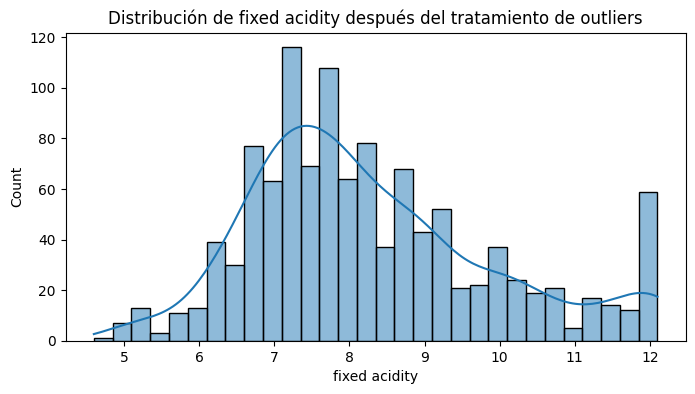

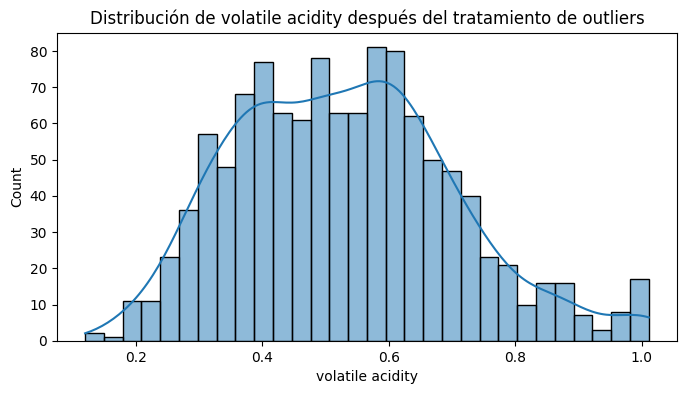

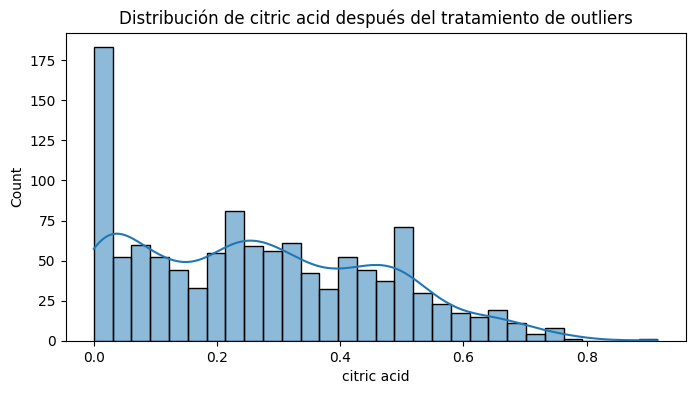

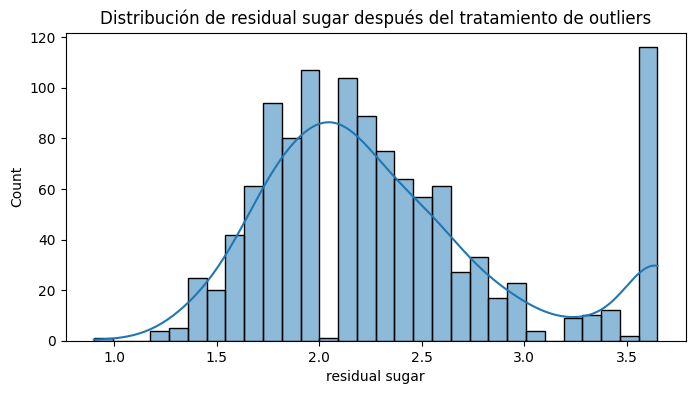

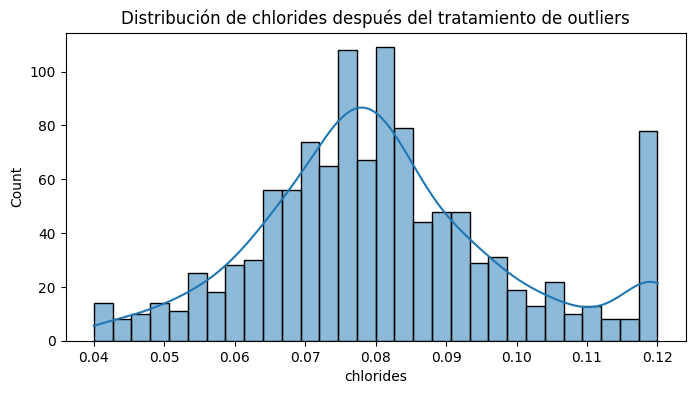

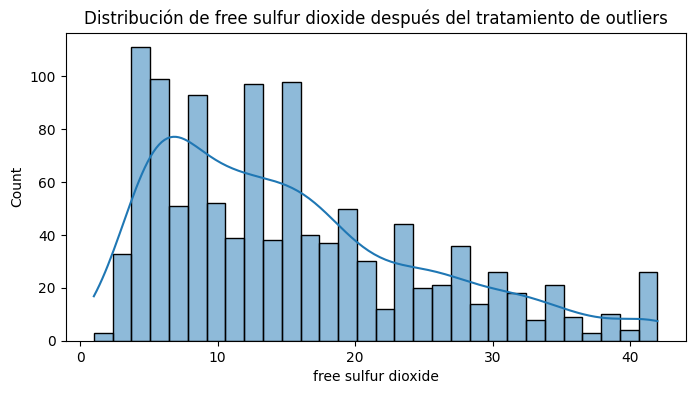

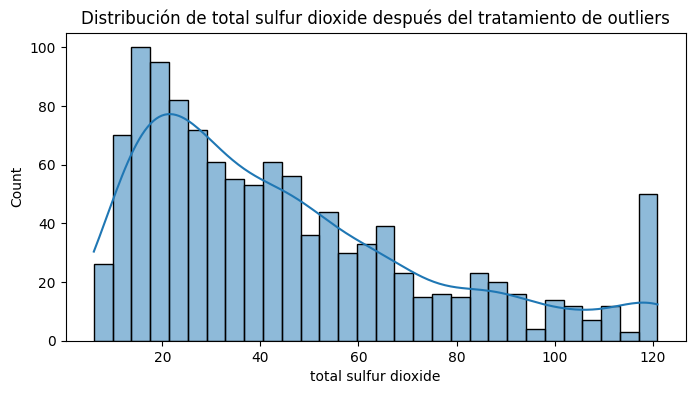

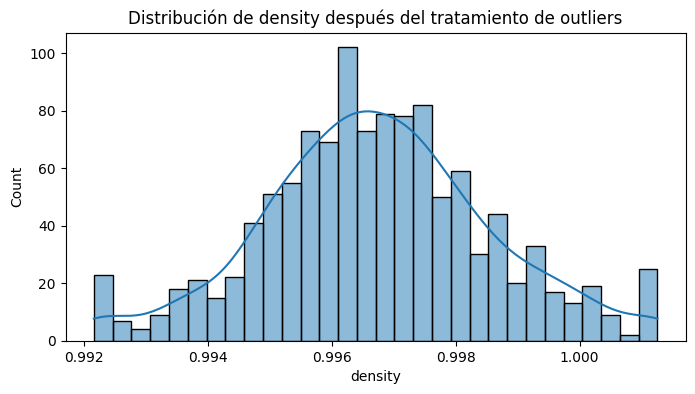

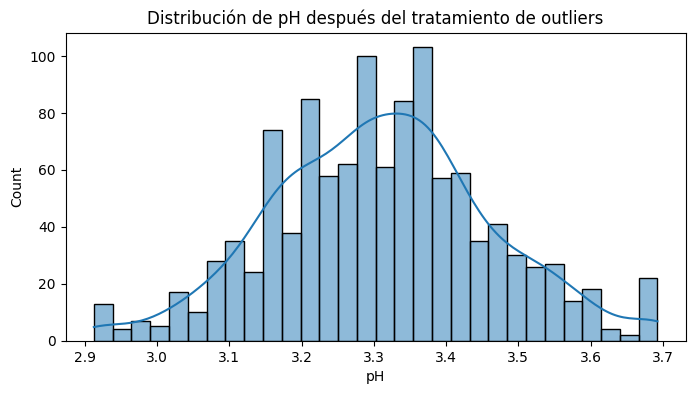

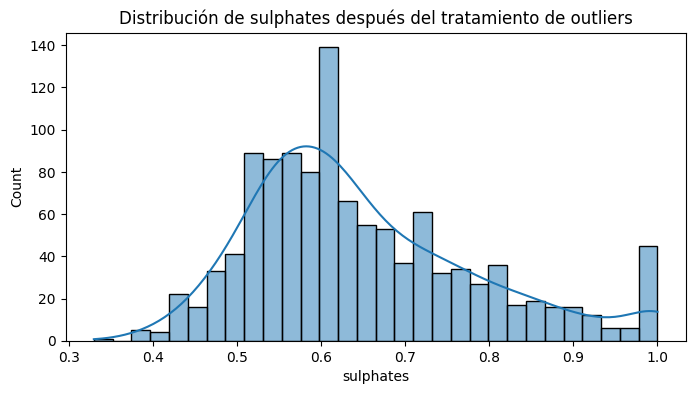

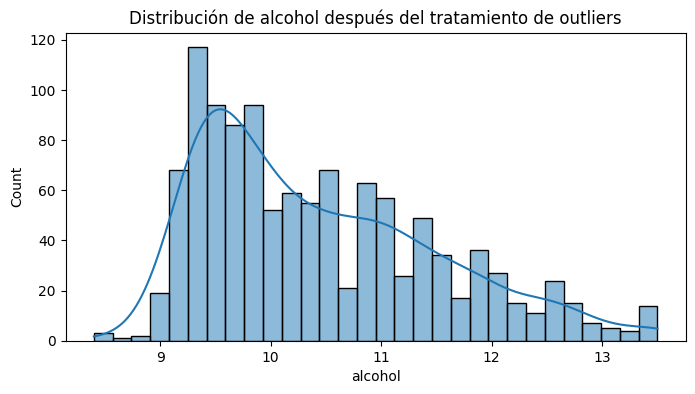

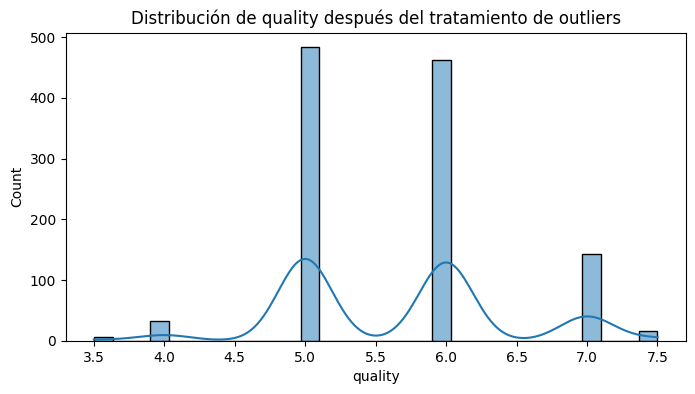

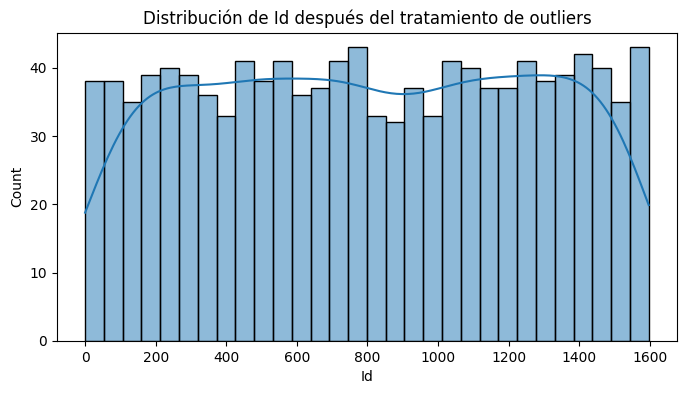

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# 1. Cargar el dataset
file_path = '/content/WineQT.csv'
data = pd.read_csv(file_path)

# 1.1 Revisar la estructura básica del dataset
print("Información del dataset:")
print(data.info())

print("\nPrimeras filas del dataset:")
print(data.head())

# 2. Descripción de las variables y su distribución
print("\nDescripción estadística de las variables:")
print(data.describe())

# Visualizar la distribución de las variables numéricas
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f'Distribución de {column}')
    plt.show()

# 3. Identificar valores nulos
print("\nValores nulos por columna:")
print(data.isnull().sum())

# 4. Tratamiento de valores nulos con SimpleImputer
# Configurar el imputador para reemplazar valores nulos con la mediana
imputer = SimpleImputer(strategy='median')
columns_with_nans = data.columns[data.isnull().any()]  # Columnas con valores nulos

if not columns_with_nans.empty:
    data[columns_with_nans] = imputer.fit_transform(data[columns_with_nans])
    print("\nValores nulos tratados usando SimpleImputer.")

# 5. Identificar y tratar outliers usando el rango intercuartil (IQR)
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Reemplazar valores fuera del rango con los límites
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])

# 6. Verificar nuevamente después del tratamiento
print("\nDescripción estadística después del tratamiento de outliers:")
print(data.describe())

# Visualizar las distribuciones después de tratar los outliers
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f'Distribución de {column} después del tratamiento de outliers')
    plt.show()

# Guardar el dataset tratado si es necesario
# data.to_csv('WineQT_cleaned.csv', index=False)


# 2. Preprocesamiento de Datos:

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier


# Verificar si la columna objetivo `quality` es continua
if data['quality'].dtype in ['float64', 'int64']:
    # Convertir `quality` en clases discretas
    bins = [0, 5, 7, 10]  # Definir los límites para las clases
    labels = ['Baja', 'Media', 'Alta']  # Etiquetas para las clases
    y = pd.cut(data['quality'], bins=bins, labels=labels)
else:
    y = data['quality']  # Si ya es categórica, usarla directamente

# Seleccionar características (excluyendo 'Id' y 'quality')
X = data.drop(columns=['Id', 'quality'])

# Identificar columnas categóricas
categorical_features = X.select_dtypes(include=['object']).columns

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),  # Imputar valores nulos con la mediana
            ('scaler', StandardScaler())  # Escalar características numéricas
        ]), X.select_dtypes(include=['float64', 'int64']).columns),

        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar valores nulos en variables categóricas
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificar variables categóricas
        ]), categorical_features)
    ])




# RandomForest

In [9]:
# Crear el modelo de clasificación
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Crear el pipeline completo
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Ajustar el modelo con los datos de entrenamiento
model_pipeline.fit(X_train, y_train)

# Evaluar el modelo
accuracy = model_pipeline.score(X_test, y_test)
print(f"Precisión del modelo en los datos de prueba: {accuracy:.4f}")

Precisión del modelo en los datos de prueba: 0.7522


# KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Crear el modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5)  # Usamos 5 vecinos como ejemplo

# Crear el pipeline completo (si ya tienes el preprocesador configurado)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn_model)
])

# Ajustar el modelo con los datos de entrenamiento
model_pipeline.fit(X_train, y_train)

# Hacer predicciones
y_pred = model_pipeline.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisión del modelo KNN en los datos de prueba: {accuracy:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))



Precisión del modelo KNN en los datos de prueba: 0.6472

Reporte de clasificación:
              precision    recall  f1-score   support

        Alta       0.00      0.00      0.00         4
        Baja       0.61      0.68      0.64       152
       Media       0.69      0.64      0.66       187

    accuracy                           0.65       343
   macro avg       0.43      0.44      0.43       343
weighted avg       0.65      0.65      0.64       343



# REGRESION LOGISTICA

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Ajustar el modelo con pesos balanceados
logistic_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Crear el pipeline completo
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logistic', logistic_model)
])

# Dividir los datos con estratificación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Ajustar el modelo
model_pipeline.fit(X_train, y_train)

# Hacer predicciones
y_pred = model_pipeline.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisión del modelo de Regresión Logística en los datos de prueba: {accuracy:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, zero_division=1))



Precisión del modelo de Regresión Logística en los datos de prueba: 0.7085

Reporte de clasificación:
              precision    recall  f1-score   support

        Alta       0.00      0.00      0.00         5
        Baja       0.73      0.79      0.76       157
       Media       0.77      0.66      0.71       181

    accuracy                           0.71       343
   macro avg       0.50      0.48      0.49       343
weighted avg       0.74      0.71      0.72       343



#4. COMPARACION DE MODELOS


Métricas de Evaluación del Modelo:
Exactitud: 0.7085
Precisión: 0.7436
Recall: 0.7085
F1-Score: 0.7231


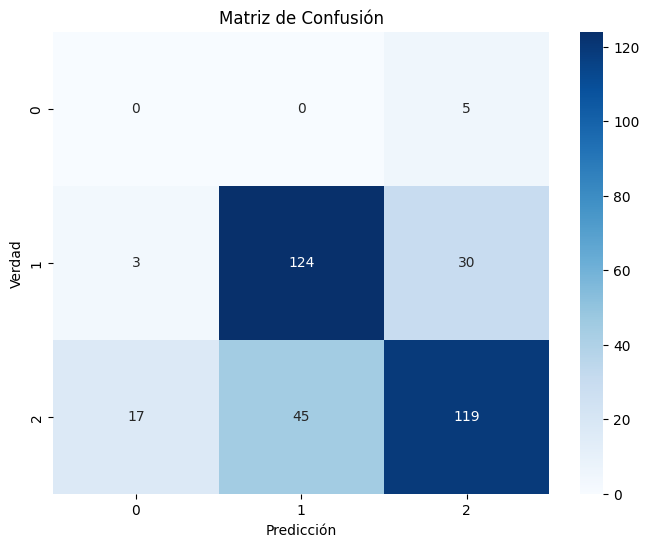


Reporte de Clasificación:
              precision    recall  f1-score   support

        Alta       0.00      0.00      0.00         5
        Baja       0.73      0.79      0.76       157
       Media       0.77      0.66      0.71       181

    accuracy                           0.71       343
   macro avg       0.50      0.48      0.49       343
weighted avg       0.74      0.71      0.72       343



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(



Métricas de Evaluación del Modelo:
Exactitud: 0.5044
Precisión: 0.5641
Recall: 0.5044
F1-Score: 0.4356


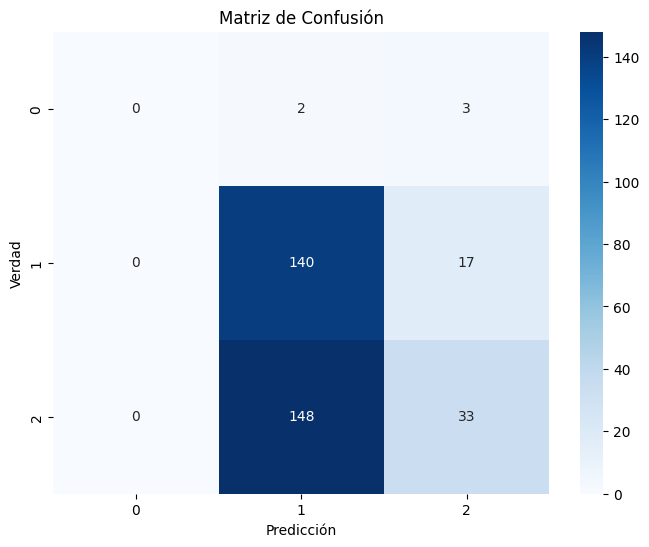


Reporte de Clasificación:
              precision    recall  f1-score   support

        Alta       1.00      0.00      0.00         5
        Baja       0.48      0.89      0.63       157
       Media       0.62      0.18      0.28       181

    accuracy                           0.50       343
   macro avg       0.70      0.36      0.30       343
weighted avg       0.56      0.50      0.44       343



In [16]:
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, roc_auc_score, accuracy_score,
                             precision_score, recall_score, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

# Evaluar el modelo
def evaluate_model(model, X_test, y_test):
    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Métricas principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\nMétricas de Evaluación del Modelo:")
    print(f"Exactitud: {accuracy:.4f}")
    print(f"Precisión: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Verdad')
    plt.show()

    # Reporte de Clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, zero_division=1))

    # Curva ROC y AUC
    if y_pred_proba is not None and len(y_test.unique()) == 2:  # Sólo para problemas binarios
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=y_test.unique()[1])
        auc = roc_auc_score(y_test, y_pred_proba)
        print(f"\nÁrea Bajo la Curva (AUC): {auc:.4f}")

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
        plt.title('Curva ROC')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc if y_pred_proba is not None and len(y_test.unique()) == 2 else None
    }

# Evaluar modelos existentes
logistic_results = evaluate_model(model_pipeline, X_test, y_test)
knn_results = evaluate_model(knn_model, X_test, y_test)


# ANALISIS Y COMPARACION DE RESULTADOS


Comparación de Modelos:
                Modelo  Exactitud  Precisión    Recall  F1-Score   AUC
0  Regresión Logística   0.708455   0.743612  0.708455  0.723110  None
1                  KNN   0.504373   0.564114  0.504373  0.435556  None


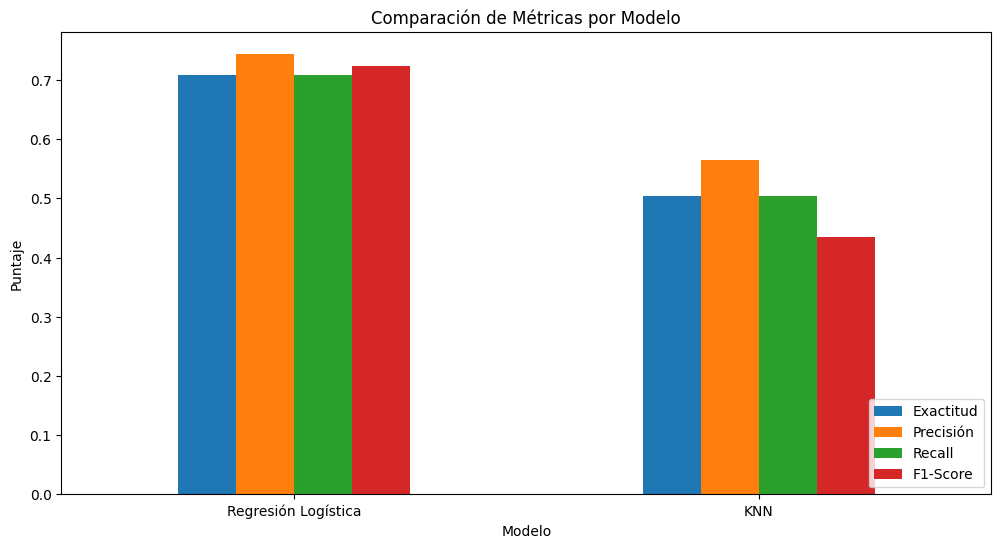


El mejor modelo es: Regresión Logística con un F1-Score de 0.7231


In [17]:
# Comparar resultados de los modelos
results = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'KNN'],
    'Exactitud': [logistic_results['accuracy'], knn_results['accuracy']],
    'Precisión': [logistic_results['precision'], knn_results['precision']],
    'Recall': [logistic_results['recall'], knn_results['recall']],
    'F1-Score': [logistic_results['f1_score'], knn_results['f1_score']],
    'AUC': [logistic_results['auc'], knn_results['auc']]
})

print("\nComparación de Modelos:")
print(results)

# Visualizar comparación
results.set_index('Modelo').plot(kind='bar', figsize=(12, 6))
plt.title('Comparación de Métricas por Modelo')
plt.ylabel('Puntaje')
plt.xlabel('Modelo')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

# Conclusión
best_model = results.loc[results['F1-Score'].idxmax()]
print(f"\nEl mejor modelo es: {best_model['Modelo']} con un F1-Score de {best_model['F1-Score']:.4f}")
